# Garch Model implement

导入数据

In [16]:
from scipy import  stats
import statsmodels.api as sm  # 统计相关的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tushare
import math
import scipy as sp
from cvxopt import matrix, solvers
a = tushare.get_hist_data('000001', start = '2017-03-01', end = '2018-03-01')
data = np.array(a.close) 

检验平稳性，是否需要差分，原假设H0：序列为非平稳的，备择假设H1:序列是平稳的.结果为不平稳，一阶差分后平稳

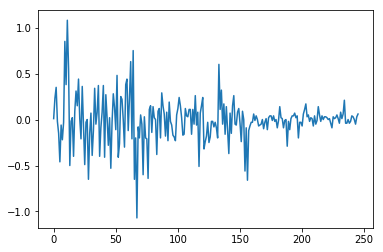

In [17]:
plt.plot(np.diff(data))
data = np.diff(data)

In [18]:
t = sm.tsa.stattools.adfuller(data)  # ADF检验
print("p-value:   ",t[1])

p-value:    0.000162115148548


建立AR模型，先判定阶次，pacf

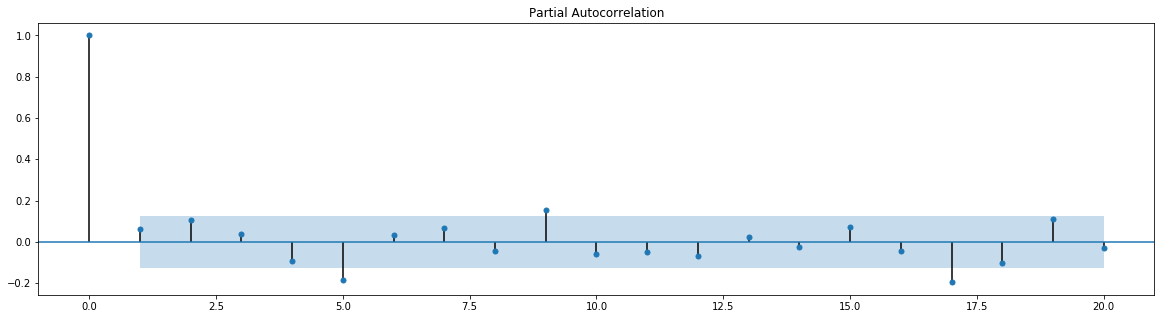

In [19]:
fig = plt.figure(figsize=(20,5))
ax1=fig.add_subplot(111)
fig = sm.graphics.tsa.plot_pacf(data,lags = 20,ax=ax1)

建立均值方程，AR(5)模型

In [20]:
order = (5,0)
model = sm.tsa.ARMA(data,order).fit()

arch效应检验

In [21]:
at = data -  model.fittedvalues
at2 = np.square(at)
m = 25 # 我们检验25个自相关系数
acf,q,p = sm.tsa.acf(at2,nlags=m,qstat=True)  ## 计算自相关系数 及p-value
out = np.c_[range(1,26), acf[1:], q, p]
output=pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"])
output = output.set_index('lag')
output

,AC,Q,P-value
lag,,,
1.0,0.060013,0.896819,3.436360e-01
2.0,0.353642,32.166623,1.035396e-07
3.0,0.160326,38.620023,2.089069e-08
4.0,0.108824,41.605559,2.013630e-08
5.0,0.225390,54.465461,1.681398e-10
6.0,0.045503,54.991785,4.653232e-10
7.0,0.112082,58.198491,3.452062e-10
8.0,0.154819,64.342568,6.509247e-11
9.0,0.132261,68.845580,2.563141e-11


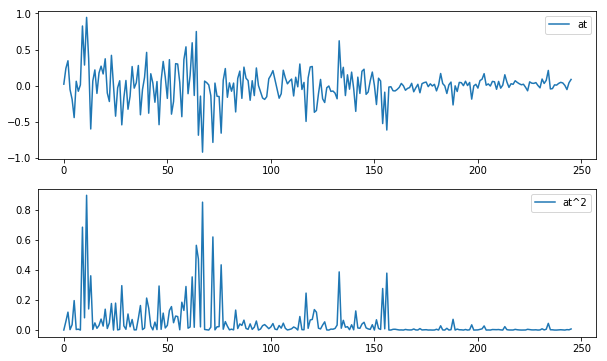

In [22]:
at = data -  model.fittedvalues
at2 = np.square(at)
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(at,label = 'at')
plt.legend()
plt.subplot(212)
plt.plot(at2,label='at^2')
plt.legend(loc=0)

In [23]:
m = 25 # 我们检验25个自相关系数
acf,q,p = sm.tsa.acf(at2,nlags=m,qstat=True)  ## 计算自相关系数 及p-value
out = np.c_[range(1,26), acf[1:], q, p]
output=pd.DataFrame(out, columns=['lag', "AC", "Q", "P-value"])
output = output.set_index('lag')
output

,AC,Q,P-value
lag,,,
1.0,0.060013,0.896819,3.436360e-01
2.0,0.353642,32.166623,1.035396e-07
3.0,0.160326,38.620023,2.089069e-08
4.0,0.108824,41.605559,2.013630e-08
5.0,0.225390,54.465461,1.681398e-10
6.0,0.045503,54.991785,4.653232e-10
7.0,0.112082,58.198491,3.452062e-10
8.0,0.154819,64.342568,6.509247e-11
9.0,0.132261,68.845580,2.563141e-11


实现GARCH(1,1)，利用极大似然估计拟合参数，进行预测

In [13]:
class Garch11(object):
    """
    An implementation of GARCH(1, 1) model
    """
        
    def __init__(self, series, alpha0 = 0.0001, alpha1 = 0.2, beta1 = 0.3):
        try:
            if alpha0 < 0 or alpha1 < 0 or beta1 < 0 or \
            alpha1 + beta1 >= 1:
                raise ValueError("Irregular coefficients")
            else:
                self.alpha0 = alpha0
                self.alpha1 = alpha1
                self.beta1 = beta1
        except ValueError:
            print("Initial condition leads to unstationary series or negative variance.")
            print("Resetting everything to default")
            self.alpha0 = 0.1
            self.alpha1 = 0.2
            self.beta1 = 0.3
        finally:
            self.mu = series.mean()
            self.sigma = series.std()
            self.size = len(series)
            self.data = series
    
    def params(self):
        """
        Returns a list of parameters
        """
        return [self.alpha0, self.alpha1, self.beta1, self.mu, self.sigma]
        
    @staticmethod
    def likelihood(param, data):
        """
        Returns negative log likelihood.
        """
        size = len(data)
        data = pd.Series(data)
        sq_resi_return = (data - param[3]) ** 2
        variance = pd.Series(param[4] ** 2)
        variance = variance.append(param[0] + param[1] * sq_resi_return.shift(1).dropna())
        
        for idx in range(1, size):
            variance.iloc[idx] = variance.iloc[idx] + param[2] *\
            variance.iloc[idx - 1] 
        
        likelihood = -(size * np.log(2 * math.pi) + np.log(variance).sum()
        + (sq_resi_return / variance).sum()) / 2
        
        return -likelihood
        
    def fit(self):  
        """
        Fit the model
        """
        cons = ({'type' : 'ineq',
                 'fun' : lambda x : np.array([x[0] - 0.000001])},
                {'type' : 'ineq',
                 'fun' : lambda x : np.array([x[1] - 0.000001])},
                {'type' : 'ineq',
                 'fun' : lambda x : np.array([x[2] - 0.000001])},
                {'type' : 'ineq',
                 'fun' : lambda x : np.array([- x[1] - x[2] + 0.999999])},
                {'type' : 'ineq',
                 'fun' : lambda x : np.array([x[4] - 0.000001])}
                 )
        print(self.params())         
        res = sp.optimize.minimize(self.likelihood, np.array(self.params()),
                             args = (np.array(self.data)), constraints = cons,
                             method = 'COBYLA',
                             options = {'disp' : True})
        
        #res = sp.optimize.minimize(self.likelihood, np.array(self.params()),
        #                           args = (self.data,))
        
        self.alpha0 = res.x[0]
        self.alpha1 = res.x[1]
        self.beta1 = res.x[2]
        self.mu = res.x[3]
        self.sigma = res.x[4]
        
    def predict(self, curr_var, sq_resid_return):
        """
        Make prediction based on fitted model
        
        Returns the next period's unconditional variance
        """
        new_var = self.alpha0 + self.alpha1 * sq_resid_return + self.beta1 * curr_var
        
        return new_var

[6e-06, 0.05, 0.9, -0.010365853658536581, 0.23984469122162808]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in log


parameters alpha0(omega), alpha1, beta1, mu, sigma are [0.00043541024480103215, 0.14919344145620023, 0.85080555854379958, -0.003548009320551047, 1.2462069172915724]


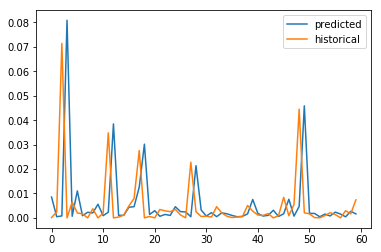

In [14]:
#Example uses 1 year's data to fit the model, and then make prediction on the
#next 3 months
#daily_return = pd.read_csv('./IF_daily_return.csv', parse_dates = 'dt', index_col = 'dt')['daily_return']
daily_return = data
variance = at2#.dropna()
garch = Garch11(daily_return, 0.000006, 0.05, 0.9)
garch.fit()
print("parameters alpha0(omega), alpha1, beta1, mu, sigma are", garch.params())
sq_resid_re = (daily_return[-61:-1] - garch.params()[3]) ** 2
data = pd.DataFrame(data = [variance[-61:-1], sq_resid_re]).transpose()
data.columns = ['sq_resid_re', 'daily_return']
pred_var = data.apply(lambda x:garch.predict(x[1], x[0]), axis = 1)
hist_var = pd.Series(variance[-60:])
pred_var.plot()
hist_var.plot()
plt.legend(['predicted', 'historical'])